# Latent Variable Models

In [1]:
import os
from collections import defaultdict
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision.utils import make_grid

Below you could see the functions which visualizes 2d data and plots the obtained training curves.

In [ ]:
def visualize_2d_data(train_data, test_data, train_labels=None, test_labels=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title('train')
    ax1.scatter(train_data[:, 0], train_data[:, 1], s=1, c=train_labels)
    ax2.set_title('test')
    ax2.scatter(test_data[:, 0], test_data[:, 1], s=1, c=test_labels)
    plt.show()


def visualize_2d_samples(data, title):
    plt.figure()
    plt.title(title)
    plt.scatter(data[:, 0], data[:, 1])
    plt.show()


def plot_training_curves(train_losses, test_losses):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Here are the functions that we will you for training out model. Please, explore these functions carefully. You do not have to change them.

In [ ]:
def train_epoch(model, train_loader, optimizer, epoch, loss_key='total'):
    model.train()
    stats = defaultdict(list)
    for x in train_loader:
        x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())
    return stats


def eval_model(model, data_loader):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(model, train_loader, test_loader, epochs, lr, loss_key='total'):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    for epoch in range(epochs):
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, epoch, loss_key)
        test_loss = eval_model(model, test_loader)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)

## Task 1: VAE on 2d data

In this task you will implement simple VAE model for 2d gaussian distribution.

We will consider two cases: 2d univariate distribution and 2d multivariate distribution. The goal is to analyze the difference between these two cases and chosen VAE model. You do not have to change data generation function.

In [104]:
def generate_2d_data(count, mode='univariate'):
    assert mode in ['univariate', 'multivariate']
    np.random.seed(42)
    mean = [[2.0, 3.0]]
    sigma = [[3.0, 1.0]]
    if mode == 'univariate':
        rotate = [
            [1.0, 0.0], 
            [0.0, 1.0]
        ]
    else:
        rotate = [
            [np.sqrt(2) / 2, np.sqrt(2) / 2], 
            [-np.sqrt(2) / 2, np.sqrt(2) / 2]
        ]
    data = mean + (np.random.randn(count, 2) * sigma).dot(rotate)
    data = data.astype('float32')
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

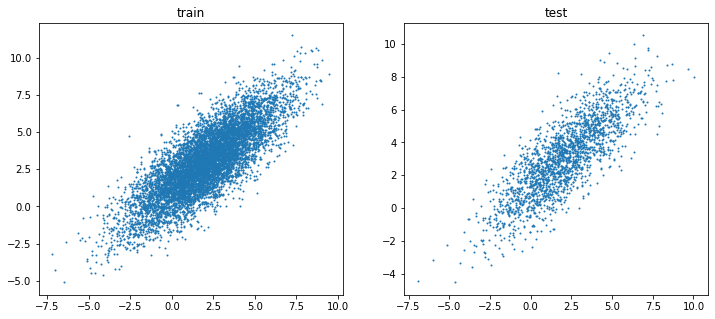

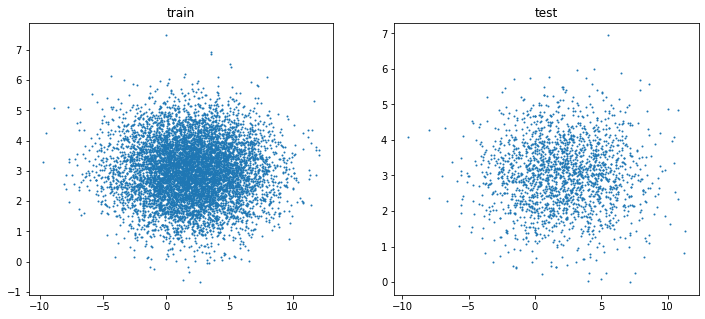

In [105]:
COUNT = 10000

train_data, test_data = generate_2d_data(COUNT, mode='multivariate')
visualize_2d_data(train_data, test_data)

train_data, test_data = generate_2d_data(COUNT, mode='univariate')
visualize_2d_data(train_data, test_data)

Now it is time to define our model. In this task you will create VAE model on 2d data. Model will be designed as:

* the latent dimensionality is equal to 2 (the same as the data dimensionality).
* prior distribution $p(\mathbf{z}) = \mathcal{N}(0, I)$.
* approximate variational distribution (or encoder) $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$. 
* posterior distribution (or decoder) $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$.
* Here the means and the covariance matrices are neural networks. Moreover, we will consider only diagonal covariance matrices.

In [31]:
class FullyConnectedMLP(nn.Module):
    def __init__(self, input_shape, hiddens, output_shape):
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        # Stack some fully connected layers wirh relu activation.
        # Note that you do not have to add relu after the last fc layer
        model = []
        self.net = nn.Sequential(*model)

    def forward(self, x):
        # place your code here


class VAE2d(nn.Module):
    def __init__(self, n_in, n_latent, enc_hidden_sizes, dec_hidden_sizes):
        assert isinstance(enc_hidden_sizes, list)
        assert isinstance(dec_hidden_sizes, list)
        super().__init__()
        self.n_latent = n_latent
        self.encoder = FullyConnectedMLP(n_in, enc_hidden_sizes, 2 * n_latent)
        self.decoder = FullyConnectedMLP(n_latent, dec_hidden_sizes, 2 * n_in)

    def prior(self, n):
        # return samples from prior distribtuion (standart normal)

    def forward(self, x):
        # place your code here
        return mu_z, log_std_z, mu_x, log_std_x

    def loss(self, x):
        mu_z, log_std_z, mu_x, log_std_x = model(x)
        # reconstruction loss is just logarithm of normal density distribution density 
        recon_loss = 
        recon_loss = recon_loss.sum(1).mean()
        
        # kl divergence of two normal distribution has analytic expression
        # https://jhui.github.io/2017/03/06/Variational-autoencoders/
        kl_loss = 
        kl_loss = kl_loss.sum(1).mean()

        return {
            'elbo_loss': recon_loss + kl_loss, 
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    def sample(self, n, noise=True):
        with torch.no_grad():
            z = self.prior(n)
            mu, log_std = self.decoder(z).chunk(2, dim=1)
            if noise:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
        return z.cpu().numpy()


def solve_task(train_data, test_data, model, batch_size, epochs, lr):
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

    train_losses, test_losses = train_model(
        model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
    )
    samples_noise = model.sample(1000, noise=True)
    samples_nonoise = model.sample(1000, noise=False)

    for key, value in test_losses.items():
        print('{}: {:.4f}'.format(key, value[-1]))

    plot_training_curves(train_losses, test_losses)
    visualize_2d_samples(samples_noise, title='Samples with Decoder Noise')
    visualize_2d_samples(samples_nonoise, title='Samples without Decoder Noise')

In [32]:
# choose these parameters

ENC_HIDDEN_SIZES = 
DEC_HIDDEN_SIZES = 
BATCH_SIZE = 
EPOCHS = 
LR = 
COUNT = 10000

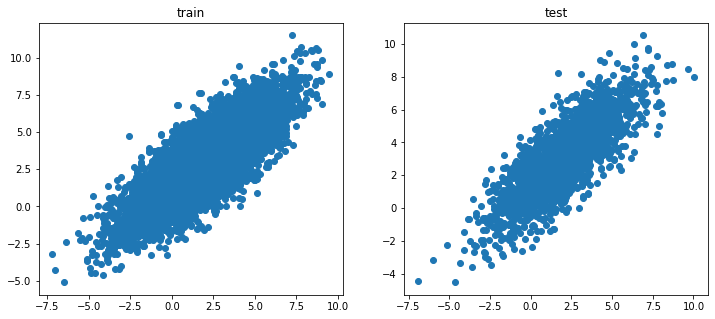

elbo_loss: 3.9361
recon_loss: 2.8430
kl_loss: 1.0932


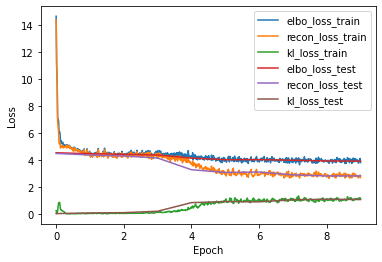

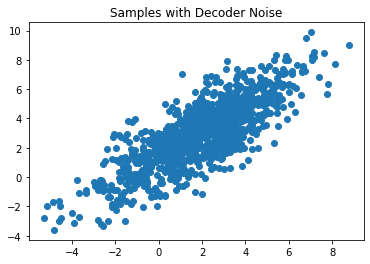

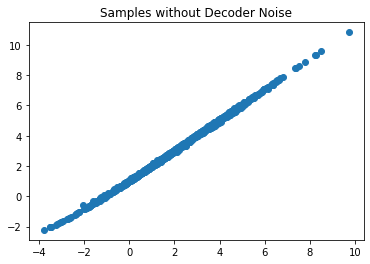

In [33]:
train_data, test_data = generate_2d_data(COUNT, mode='multivariate')
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).cuda()
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR)

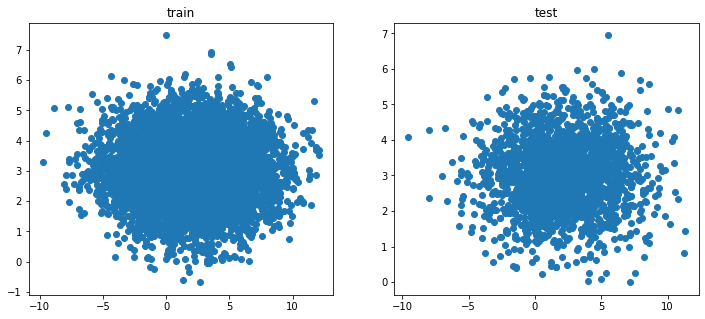

elbo_loss: 3.9475
recon_loss: 3.9362
kl_loss: 0.0113


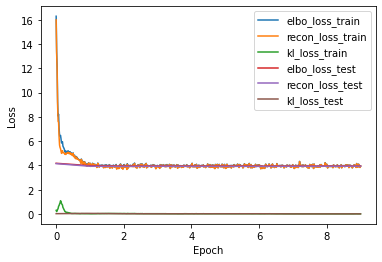

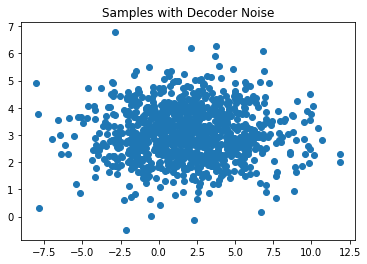

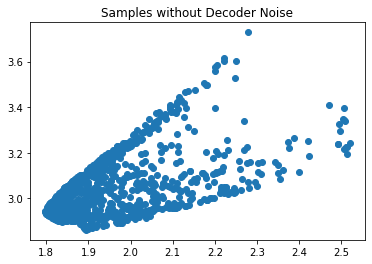

In [35]:
train_data, test_data = generate_2d_data(COUNT, mode='univariate')
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).cuda()
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR)

After training the model on these 2 datasets, you have to see on "Samples without Decoder Noise" figures. This figures shows posterior means of the decoder. In the case of multivariate gaussian, the means are perfectly aligned with data distribution. 
Otherwise, in the of univariate gaussian you have to see strange figure. This happens due to so called "posterior collapse" (we will discuss it on the one of our lecture).
Our posterior distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$ is a univariate (covariance matrix is diagonal). Thus, to model univariate data distribution (second case) the model ignores latent code, cause we could model it without any information from latent space.
It is a real problem for generative models and we will discuss later how to overcome this problem.

## Task 2: VAE on CIFAR10 data

In this task you will implement VAE model for real image distribution. You do not have to change this functions (except the path to the data file, download it from here: https://drive.google.com/file/d/16j3nrJV821VOkkuRz7aYam8TyIXLnNme/view?usp=sharing).

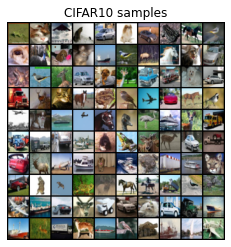

In [49]:
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    train_data, test_data = data['train'], data['test']
    return train_data, test_data


def show_samples(samples, title, nrow=10):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


def visualize_data(data, title):
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = train_data[idxs]
    show_samples(images, title)

train_data, test_data = load_pickle(os.path.join('drive', 'My Drive', 'DGM2020', 'cifar10.pkl'))
visualize_data(train_data, 'CIFAR10 samples')

Here the model specification will be almost the same with the following differences:
* Now our encoder and decoder will be convolutional.
* We do not model covariance matrix in posterior distribution (now it is identical).

In [51]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent
        self.convs = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[1] // 8 * input_shape[2] // 8 * 256
        self.fc = nn.Linear(conv_out_dim, 2 * n_latent)

    def forward(self, x):
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std
        

class ConvDecoder(nn.Module):
    def __init__(self, n_latent, output_shape):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        self.fc = nn.Linear(n_latent, np.prod(self.base_size))
        self.deconvs = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, output_shape[0], 3, padding=1),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], *self.base_size)
        return self.deconvs(out)


class ConvVAE(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.encoder = ConvEncoder(input_shape, n_latent)
        self.decoder = ConvDecoder(n_latent, input_shape)

    def prior(self, n):
        return torch.randn(n, self.n_latent).cuda()

    def forward(self, x):
        # place your code here
        return mu_z, log_std_z, x_recon
        
    def loss(self, x):
        mu_z, log_std_z, x_recon = model(x)
        # use F.mse_loss for recon_loss
        recon_loss = 
        kl_loss = 

        return {
            'elbo_loss': recon_loss + kl_loss, 
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    def sample(self, n):
        with torch.no_grad():
            z = self.prior(n)
            x_recon = self.decoder(z)
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5

elbo_loss: 250.8719
recon_loss: 221.0356
kl_loss: 29.8363


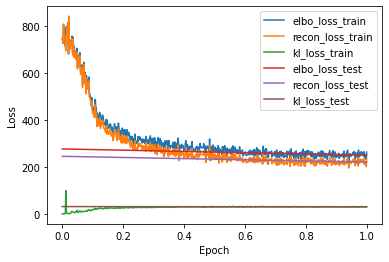

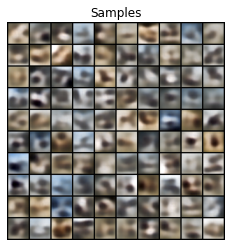

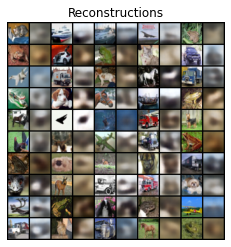

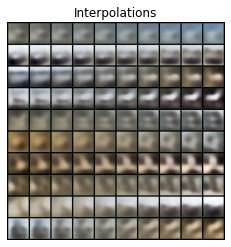

In [56]:
# choose these parameters

BATCH_SIZE = 
EPOCHS = 
LR = 

train_data, test_data = load_pickle(os.path.join('drive', 'My Drive', 'DGM2020', 'cifar10.pkl'))

train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255. * 2 - 1).astype('float32')
test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255. * 2 - 1).astype('float32')

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

model = ConvVAE((3, 32, 32), 16).cuda()
train_losses, test_losses = train_model(
    model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
)
samples = model.sample(100) * 255.

x = next(iter(test_loader))[:50].cuda()
with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() * 255

x = next(iter(test_loader))[:20].cuda()
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.permute(0, 2, 3, 1).cpu().numpy() * 255

samples, reconstructions, interps = samples.astype('float32'), reconstructions.astype('float32'), interps.astype('float32')
for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
plot_training_curves(train_losses, test_losses)
show_samples(samples, title='Samples')
show_samples(reconstructions, title='Reconstructions')
show_samples(interps, title='Interpolations')

## Task 3: RealNVP on 2d data

In this task you will implement RealNVP modelon 2d moons dataset. Your do not have to change the data generation function.

In [93]:
def generate_moons_data(count):
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype('float32')
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

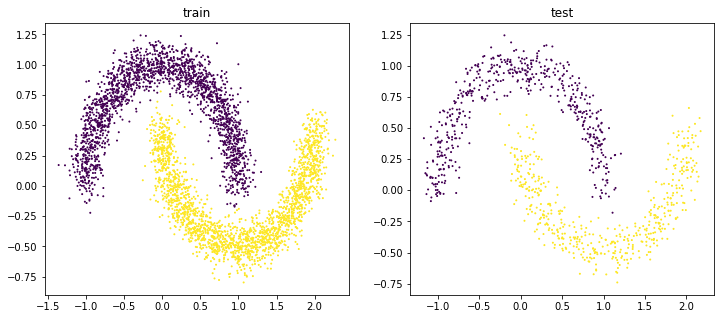

In [102]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

See original paper for model description (https://arxiv.org/abs/1605.08803).

The model is a sequence of affine coupning layers. Note that you have to permute the channels that will left unchanged between different layers.

In [89]:
class AffineTransform(nn.Module):
    def __init__(self, partition_type, n_hiddens=[256, 256]):
        super().__init__()
        self.mask = self.build_mask(partition_type=partition_type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.mlp = FullyConnectedMLP(input_shape=2, hiddens=n_hiddens, output_shape=2)

    def build_mask(self, partition_type):
        assert partition_type in {"left", "right"}
        # place your code here

    def forward(self, x, invert=False):
        # place your code here (you have to mask x)

        log_s, t = self.mlp(x_masked).split(1, dim=1)
        # see original paper to understand these formulas
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)

        #place your code here
        # you have to create forward and inverse transforms (use invert flag)
        return x, log_s


class RealNVP(nn.Module):
    def __init__(self):
        super().__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))
        self.transforms = nn.ModuleList([
            # place your code here (stack AffineTransform) with alternately changing partition_mode
        ])
        
    def forward(self, x, invert=False):
        z = x
        log_det = 0.0
        # place your code here (do not forget abour invert flag)
        return z, log_det

    def log_prob(self, x):
        # place your code here (use forward method)

    def loss(self, x):
        return {'nll_loss': -self.log_prob(x).mean()}

    def sample(self, n):
        # place your code here (sample from prior and put it to forward)

In [83]:
def show_2d_latents(latents, labels, title='Latent Space'):
    plt.figure()
    plt.title(title)
    plt.scatter(latents[:, 0], latents[:, 1], s=1, c=labels)
    plt.xlabel('z1')
    plt.ylabel('z2')

    plt.show()

def show_2d_densities(densities, title='Densities'):
    plt.figure()
    plt.title(title)
    dx, dy = 0.025, 0.025
    x_lim = (-1.5, 2.5)
    y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
    plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.show()

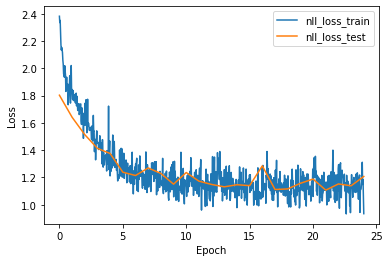

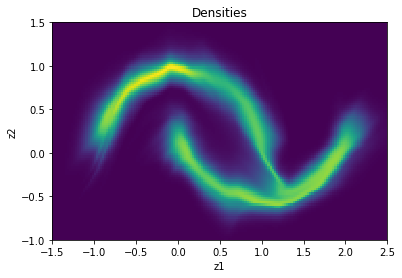

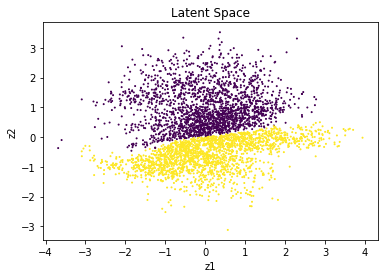

In [90]:
# choose these parameters

BATCH_SIZE = 
EPOCHS = 
LR = 
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)

loader_args = dict(batch_size=BATCH_SIZE, shuffle=True)
train_loader = data.DataLoader(train_data, **loader_args)
test_loader = data.DataLoader(test_data, **loader_args)

# model
real_nvp = RealNVP().cuda()

# train
train_losses, test_losses = train_model(
    real_nvp, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='nll_loss'
)

# heatmap
dx, dy = 0.025, 0.025
x_lim = (-1.5, 2.5)
y_lim = (-1, 1.5)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]
mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).cuda()
densities = np.exp(real_nvp.log_prob(mesh_xs).cpu().detach().numpy())

# latents
z = real_nvp(torch.FloatTensor(train_data).cuda())[0]
latents = z.cpu().detach().numpy()

plot_training_curves(train_losses, test_losses)
show_2d_densities(densities)
show_2d_latents(latents, train_labels)